In [ ]:
import re
from zipfile import ZipFile
import pandas as pd

from pathlib import Path
from zipfile import ZipFile
from typing import List
from cassis import load_typesystem, load_cas_from_xmi, Cas
from dataclasses import dataclass
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score
from seqeval.scheme import IOB2
from seqeval.scheme import IOB1
import numpy as np
from sklearn.metrics import cohen_kappa_score
import json
import matplotlib.pyplot as plt
import spacy
nlp = spacy.load("es_core_news_sm")

from pprint import pprint
from seqeval.metrics import classification_report
from seqeval.metrics import accuracy_score

In [80]:
ENTITY_CLASSES = ["Agente", "Mecanismo"]

# Extract annotations

In [ ]:
def load_corpus(corpusfile: Path, limit: int = 0, annotation_type: str = "annotation", annotator_name: str = "", ids_to_analyze = ids_traslape) -> List[Cas]:
    """
    Load the corpus from the given zip file.
    """
    n = 0
    corpus = []
    with ZipFile(corpusfile, 'r') as corpuszip:
        for path in corpuszip.namelist():
            doc_id = re.search(r"/(.+?)\.txt", path)
            if doc_id is not None:
                doc_id = doc_id.group(1)
                if doc_id + ".txt" in ids_to_analyze:
                    if path.startswith(f"{annotation_type}/") & path.endswith(f"{annotator_name}.zip"):
                        with ZipFile(corpuszip.open(path), 'r') as annotationzip:
                            with annotationzip.open('TypeSystem.xml', 'r') as f:
                                typesystem = load_typesystem(f)
                            if annotator_name == "":
                                name = "CURATION_USER"
                            else:
                                name = annotator_name
                            with annotationzip.open(f"{name}.xmi", 'r') as f:
                                cas = load_cas_from_xmi(f, typesystem=typesystem)
                                title = cas.select(
                "de.tudarmstadt.ukp.dkpro.core.api.metadata.type.DocumentMetaData")[0].documentTitle
                            corpus.append(cas)
                            n += 1
                            print(f"Loaded {n} documents", end="\r")
                            if (limit > 0) & (n >= limit):
                                break

    if len(corpus) == 0:
        raise Exception("No documents found in corpus file. Maybe UIMA CAS documents are not present?")
    return corpus


In [83]:
reports_true = load_corpus(Path("annotated_corpus.zip"), annotation_type="curation", ids_to_analyze = ids_traslape)

In [84]:
reports_1 = load_corpus(Path("annotated_corpus.zip"), annotator_name="arubio", ids_to_analyze = ids_anotador_1)
reports_2 = load_corpus(Path("annotated_corpus.zip"), annotator_name="gberrios", ids_to_analyze = ids_anotador_2)

In [ ]:
@dataclass
class Document:
    name: str
    text: str


def extract_annotation(document: Cas, user: str, classes_to_analyze: list) -> Document:
    name = document.select(
        "de.tudarmstadt.ukp.dkpro.core.api.metadata.type.DocumentMetaData")[0].documentTitle
    text = document.sofa_string
    entities = document.select(
        "de.tudarmstadt.ukp.dkpro.core.api.ner.type.NamedEntity")
    if user != "curation":
        document_label = document.select("custom.DocumentLabel")[0].Code
        if document_label is not None and "#" in document_label:
            document_label = document_label.split("#")[1]
    else:
        if name in ids_traslape:
            document_label = dict_ids_c_externas[name]
        else:
            document_label = "None"

    secondary_entities =[ entities[i].identifier.split("#")[1] for i in range(len(entities)) if (entities[i].identifier != None and entities[i].value in classes_to_analyze)]
    secondary_entities = list(dict.fromkeys(secondary_entities))
    
    entity_classes_of_doc = [entitie.value for entitie in entities if entitie.value in classes_to_analyze]
    entity_classes_of_doc = list(dict.fromkeys(entity_classes_of_doc))
    
    annotation = {"Text": text, "Label": {entity_class: [] for entity_class in entity_classes_of_doc}, "Secondary_Label": {entity_class: [] for entity_class in secondary_entities}}
    for entity_class in entity_classes_of_doc:
        for entity in entities:
            if entity.value == entity_class:
                annotation["Label"][entity_class].append([text[entity.begin:entity.end], entity.begin, entity.end])
    for entity_class in secondary_entities:
        for entity in entities:
            if entity.identifier == None:
                continue
            elif entity.identifier.split("#")[1] == entity_class:
                annotation["Secondary_Label"][entity_class].append([text[entity.begin:entity.end], entity.begin, entity.end])

    annotation["id"] = name
    # add the Document Label
    annotation["id_siniestro"] = name[5:-4]
    annotation["Document_Label"] = document_label
    
    return annotation

In [ ]:

import pandas as pd

df = pd.read_csv("corpus.csv", sep=",")
df["id_siniestro"] = df["id_siniestro"].astype(str)
df["mecanismo"] = df["mecanismo"].astype(str)

def agregar_cero(mecanismo):
    if len(mecanismo.split(".")[1]) == 1:
        return mecanismo + "0"
    return mecanismo

df["mecanismo"] = df["mecanismo"].apply(agregar_cero)

In [87]:
mec_reports_2 = [extract_annotation(doc, "", ["Mecanismo"]) for doc in reports_2 if extract_annotation(doc, "", ["Mecanismo"])["Text"].lower() != "nan"]
mec_reports_1 = [extract_annotation(doc, "", ["Mecanismo"]) for doc in reports_1 if extract_annotation(doc, "", ["Mecanismo"])["Text"].lower() != "nan"]
mec_reports_true = [extract_annotation(doc, "curation", ["Mecanismo"]) for doc in reports_true if extract_annotation(doc, "curation", ["Mecanismo"])["Text"].lower() != "nan"]

ag_reports_2 = [extract_annotation(doc, "", ["Agente"]) for doc in reports_2 if extract_annotation(doc, "", ["Agente"])["Text"].lower() != "nan"]
ag_reports_1 = [extract_annotation(doc, "", ["Agente"]) for doc in reports_1 if extract_annotation(doc, "", ["Agente"])["Text"].lower() != "nan"]
ag_reports_true = [extract_annotation(doc, "curation", ["Agente"]) for doc in reports_true if extract_annotation(doc, "curation", ["Agente"])["Text"].lower() != "nan"]


In [ ]:
id_siniestros = [annotation["id_siniestro"] for annotation in mec_reports_true]

df_curation = df[df["id_siniestro"].isin(id_siniestros)].copy()
df_curation["Document_Label_true"] = df_curation["id_siniestro"].map({annotation["id_siniestro"]: annotation["Document_Label"] for annotation in mec_reports_true})
df_curation["mecanismo_true"] = df_curation["id_siniestro"].map({annotation["id_siniestro"]: annotation for annotation in mec_reports_true})
df_curation["agente_true"] = df_curation["id_siniestro"].map({annotation["id_siniestro"]: annotation for annotation in ag_reports_true})

In [90]:
ids_siniestros_1 = [annotation["id_siniestro"] for annotation in mec_reports_1]
ids_siniestros_2 = [annotation["id_siniestro"] for annotation in mec_reports_2]

df_1 = df[df["id_siniestro"].isin(ids_siniestros_1)].copy()
df_2 = df[df["id_siniestro"].isin(ids_siniestros_2)].copy()

df_1["Document_Label_1"] = df_1["id_siniestro"].map({annotation["id_siniestro"]: annotation["Document_Label"] for annotation in mec_reports_1})
df_1["mecanismo_1"] = df_1["id_siniestro"].map({annotation["id_siniestro"]: annotation for annotation in mec_reports_1})
df_1["agente_1"] = df_1["id_siniestro"].map({annotation["id_siniestro"]: annotation for annotation in ag_reports_1})

df_2["Document_Label_2"] = df_2["id_siniestro"].map({annotation["id_siniestro"]: annotation["Document_Label"] for annotation in mec_reports_2})
df_2["mecanismo_2"] = df_2["id_siniestro"].map({annotation["id_siniestro"]: annotation for annotation in mec_reports_2})
df_2["agente_2"] = df_2["id_siniestro"].map({annotation["id_siniestro"]: annotation for annotation in ag_reports_2})

In [91]:
ids_anotados = ids_siniestros_1 + ids_siniestros_2 + id_siniestros

In [92]:
reports_1_ann = [extract_annotation(doc, "", ENTITY_CLASSES) for doc in reports_1 if extract_annotation(doc, "", ENTITY_CLASSES)["Text"].lower() != "nan"]
reports_2_ann = [extract_annotation(doc, "", ENTITY_CLASSES) for doc in reports_2 if extract_annotation(doc, "", ENTITY_CLASSES)["Text"].lower() != "nan"]
reports_true_ann = [extract_annotation(doc, "curation", ENTITY_CLASSES) for doc in reports_true if extract_annotation(doc, "curation", ENTITY_CLASSES)["Text"].lower() != "nan"]


In [93]:
mec_reports_2 = [doc for doc in mec_reports_2 if doc["id"] in ids_traslape]
mec_reports_1 = [doc for doc in mec_reports_1 if doc["id"] in ids_traslape]
mec_reports_true = [doc for doc in mec_reports_true if doc["id"] in ids_traslape]

ag_reports_2 = [doc for doc in ag_reports_2 if doc["id"] in ids_traslape]
ag_reports_1 = [doc for doc in ag_reports_1 if doc["id"] in ids_traslape]
ag_reports_true = [doc for doc in ag_reports_true if doc["id"] in ids_traslape]

reports_1_ann = [doc for doc in reports_1_ann if doc["id"] in ids_traslape]
reports_2_ann = [doc for doc in reports_2_ann if doc["id"] in ids_traslape]
reports_true_ann = [doc for doc in reports_true_ann if doc["id"] in ids_traslape]


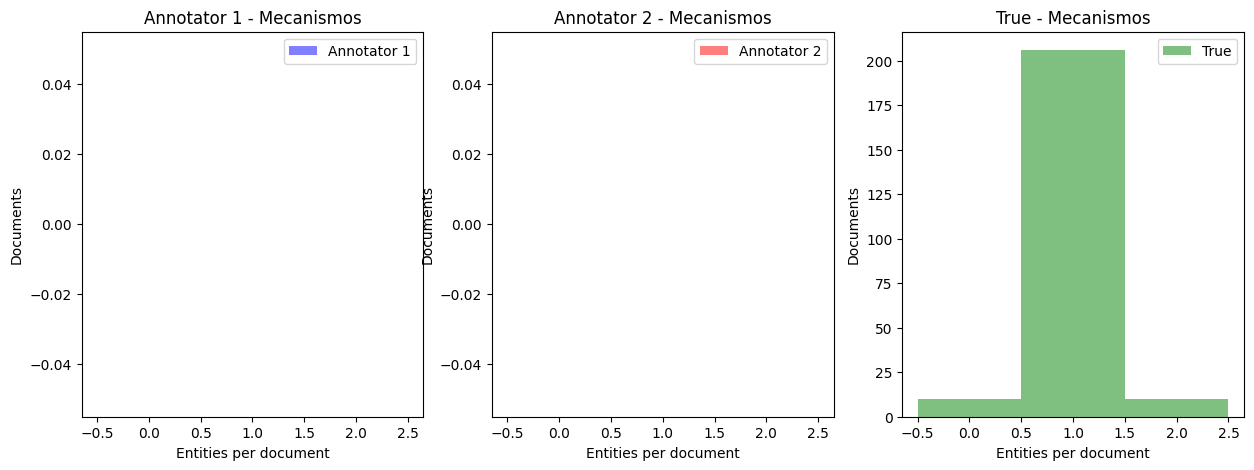

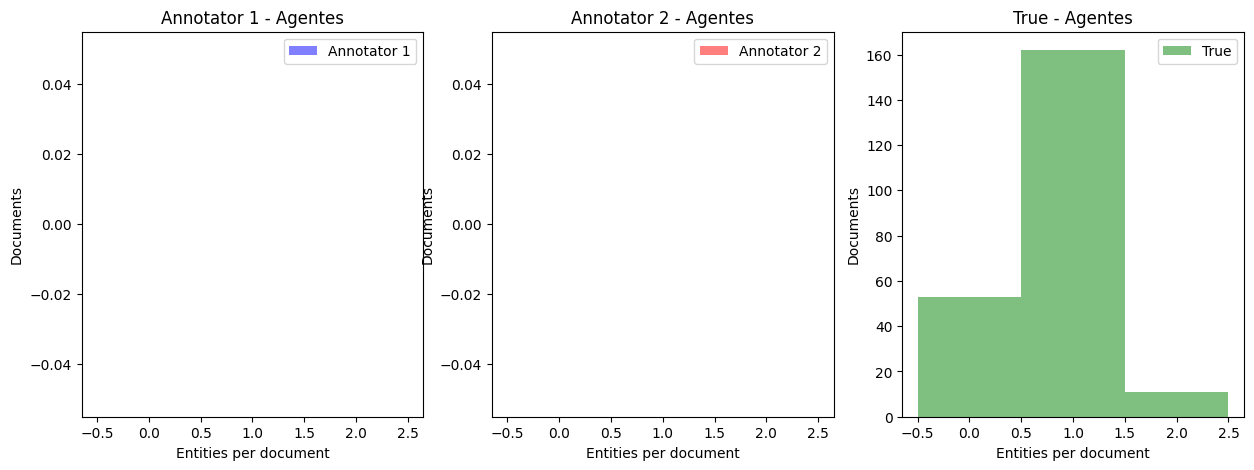

In [ ]:
def get_entities_per_doc(reports):
    entities_per_doc = []
    for report in reports:
        entities_per_doc.append({report["id"]: {entity_class: len(annotations) for entity_class, annotations in report["Label"].items()}})
    for report in entities_per_doc:
        for doc in report:
            for entity_class in ENTITY_CLASSES:
                if entity_class not in report[doc]:
                    report[doc][entity_class] = 0
    mecanismos_per_doc = []
    agentes_per_doc = []
    for report in entities_per_doc:
        for doc in report:
            report[doc] = list(report[doc].values())
            mecanismos_per_doc.append(report[doc][0])
            agentes_per_doc.append(report[doc][1])
    return mecanismos_per_doc, agentes_per_doc


mecanismos_per_doc_1, agentes_per_doc_1 = get_entities_per_doc(reports_1_ann)
mecanismos_per_doc_2, agentes_per_doc_2 = get_entities_per_doc(reports_2_ann)
mecanismos_per_doc_true, agentes_per_doc_true = get_entities_per_doc(reports_true_ann)


def plot_entities_per_doc(entities_per_doc_1, entities_per_doc_2, entities_per_doc_true, entity_type):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].hist(entities_per_doc_1, bins=range(0, 4), align="left", color="b", alpha=0.5, label="Annotator 1")
    ax[1].hist(entities_per_doc_2, bins=range(0, 4), align="left", color="r", alpha=0.5, label="Annotator 2")
    ax[2].hist(entities_per_doc_true, bins=range(0, 4), align="left", color="g", alpha=0.5, label="True")
    ax[0].set_title(f"Annotator 1 - {entity_type}")
    ax[1].set_title(f"Annotator 2 - {entity_type}")
    ax[2].set_title(f"True - {entity_type}")
    ax[0].set_xlabel("Entities per document")
    ax[1].set_xlabel("Entities per document")
    ax[2].set_xlabel("Entities per document")
    ax[0].set_ylabel("Documents")
    ax[1].set_ylabel("Documents")
    ax[2].set_ylabel("Documents")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.show()

plot_entities_per_doc(mecanismos_per_doc_1, mecanismos_per_doc_2, mecanismos_per_doc_true, "Mecanismos")
plot_entities_per_doc(agentes_per_doc_1, agentes_per_doc_2, agentes_per_doc_true, "Agentes")

In [ ]:

def get_tokens_from_annotation(text, annotation):
    tokens = nlp(text)
    character_start = annotation[1]
    character_end = annotation[2]
    annotated_tokens = []

    for token in tokens:
        start_token = token.idx
        end_token = token.idx + len(token.text) 

        if (start_token >= character_start and end_token <= character_end) or \
           (start_token <= character_start and end_token >= character_start):
            
            annotated_tokens.append(list(tokens).index(token) )
    return annotated_tokens

def annotation_2_conll_seqeval(annotations, label, curated=False):
    text = annotations["Text"]
    tokens = nlp(text)
    if label == "Document_Label":
        return [annotations[label]]
    if curated:
        labels = annotations["Label"]
        
    labels = annotations[label]
    conll = ["O" for token in tokens]
    for entity_class, entities in labels.items():
        for entity in entities:
            annotated_tokens = get_tokens_from_annotation(text, entity)
            conll[annotated_tokens[0]] = f"B-{entity_class}"
            for token in annotated_tokens[1:]: 
                conll[token] = f"I-{entity_class}"
    return conll


In [96]:
def gen_mec_secondary_label(entity_reports):
    entity_reports_secondary = []
    for i in range(len(entity_reports)):
        if len(entity_reports[i]["Secondary_Label"]) == 0:
            entity_reports_secondary.append(["92.20"])
        else:
            if len(list(entity_reports[i]["Secondary_Label"].keys())[0]) != 5:
                entity_reports_secondary.append([list(entity_reports[i]["Secondary_Label"].keys())[0]+ "0"])
            else:
                entity_reports_secondary.append([list(entity_reports[i]["Secondary_Label"].keys())[0]])
    return entity_reports_secondary

def gen_ag_secondary_label(entity_reports):
    entity_reports_secondary = []
    for i in range(len(entity_reports)):
        
        if len(entity_reports[i]["Secondary_Label"]) == 0:
            entity_reports_secondary.append(["700.0"])
        else:
            if len(list(entity_reports[i]["Secondary_Label"].keys())[0]) < 5:
                entity_reports_secondary.append([list(entity_reports[i]["Secondary_Label"].keys())[0]+".0"])
            if len(list(entity_reports[i]["Secondary_Label"].keys())[0]) > 5:
                entity_reports_secondary.append([list(entity_reports[i]["Secondary_Label"].keys())[0][:3]+".0"])
            elif len(list(entity_reports[i]["Secondary_Label"].keys())[0]) == 5:
                entity_reports_secondary.append([list(entity_reports[i]["Secondary_Label"].keys())[0]])
    return entity_reports_secondary

In [97]:
y_mec_1_reports_secondary = gen_mec_secondary_label(mec_reports_1)
y_mec_2_reports_secondary = gen_mec_secondary_label(mec_reports_2)
y_mec_true_secondary = gen_mec_secondary_label(mec_reports_true)
y_ag_1_reports_secondary = gen_ag_secondary_label(ag_reports_1)
y_ag_2_reports_secondary = gen_ag_secondary_label(ag_reports_2)
y_ag_true_secondary = gen_ag_secondary_label(ag_reports_true)

In [99]:
df_curation["mecanismo_true"] = df_curation["mecanismo_true"].apply(lambda x: gen_mec_secondary_label([x])[0][0])
df_curation["agente_true"] = df_curation["agente_true"].apply(lambda x: gen_ag_secondary_label([x])[0][0])

df_1["mecanismo_1"] = df_1["mecanismo_1"].apply(lambda x: gen_mec_secondary_label([x])[0][0])
df_1["agente_1"] = df_1["agente_1"].apply(lambda x: gen_ag_secondary_label([x])[0][0])

df_2["mecanismo_2"] = df_2["mecanismo_2"].apply(lambda x: gen_mec_secondary_label([x])[0][0])
df_2["agente_2"] = df_2["agente_2"].apply(lambda x: gen_ag_secondary_label([x])[0][0])

df_1["mecanismo_true"]  = df_1["mecanismo_1"] 
df_2["mecanismo_true"]  = df_2["mecanismo_2"] 


In [ ]:
y_mec_1_reports = [annotation_2_conll_seqeval(annotation,"Label") for annotation in mec_reports_1]
y_mec_2_reports = [annotation_2_conll_seqeval(annotation,"Label") for annotation in mec_reports_2]
y_mec_true = [annotation_2_conll_seqeval(annotation,"Label") for annotation in mec_reports_true]

y_ag_1_reports = [annotation_2_conll_seqeval(annotation,"Label") for annotation in ag_reports_1]
y_ag_2_reports = [annotation_2_conll_seqeval(annotation,"Label") for annotation in ag_reports_2]
y_ag_true = [annotation_2_conll_seqeval(annotation,"Label") for annotation in ag_reports_true]




y_doc_1 = [annotation_2_conll_seqeval(annotation, "Document_Label") for annotation in mec_reports_1]
y_doc_2 = [annotation_2_conll_seqeval(annotation, "Document_Label") for annotation in mec_reports_2]
y_doc_true = [annotation_2_conll_seqeval(annotation, "Document_Label") for annotation in mec_reports_true]



# Inter Annotator Agreement

## Helpers:

In [ ]:
def relaxed_f1_score(true_annotations, pred_annotations, label = "Label", verbose=False, mode="relaxed"):

    true_values = []
    for annotation in true_annotations:
        true_values_annotation = []
        for entity_class in annotation[label]:
            for entity in annotation[label][entity_class]:
                true_values_annotation.append((entity_class, entity[1], entity[2], entity[0],))
        true_values.append(true_values_annotation)
    pred_values = []
    for annotation in pred_annotations:
        pred_values_annotation = []
        for entity_class in annotation[label]:
            for entity in annotation[label][entity_class]:
                pred_values_annotation.append((entity_class, entity[1], entity[2], entity[0]))
        pred_values.append(pred_values_annotation)
    

    correct = 0
    total = 0
    for i in range(len(pred_values)):
        for pred_value in pred_values[i]:
            for true_value in true_values[i]:
                if pred_value[2] == true_value[2] and pred_value[1] == true_value[1] and pred_value[0] == true_value[0]:
                    if verbose:
                        print("Prediccion correcta, con exactitud: ")
                        print(pred_value, true_value)
                        print(f"Nombre del documento: {pred_annotations[i]['id']}")
                    correct += 1
                    break
                elif pred_value[2] >= true_value[1] and pred_value[1] <= true_value[2] and pred_value[0] == true_value[0]:
                    if verbose:
                        print("Prediccion correcta con traslape: ")
                        print(pred_value, true_value)
                        print(f"Nombre del documento: {pred_annotations[i]['id']}")
                    if mode == "relaxed":
                        correct += 1
                    break
                elif true_value[2] >= pred_value[1] and true_value[1] <= pred_value[2] and pred_value[0] == true_value[0]:
                    if verbose:
                        print("Prediccion correcta con traslape: ")
                        print(pred_value, true_value)
                        print(f"Nombre del documento: {pred_annotations[i]['id']}")
                    if mode == "relaxed":
                        correct += 1
                    break
            total += 1
    if total != 0:
        precision = correct / total
    recall = correct / sum([len(true_value) for true_value in true_values])
    if precision + recall != 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    support = sum([len(true_value) for true_value in true_values])
    f1 = round(f1, 2)
    precision = round(precision, 2)
    recall = round(recall, 2)

    dict_results = {"f1": f1, "precision": precision, "recall": recall, "support": support}
    return dict_results


In [ ]:
def classification_report_2_dataframe(class_report):
    class_report = class_report.split("\n")
    class_report = [line.split() for line in class_report if line != ""]
    columns = ["entity_class"] + class_report[0]
    data = class_report[1:-3]
    class_report = pd.DataFrame(data, columns=columns)
    for entity_class in ENTITY_CLASSES:
        if entity_class not in class_report["entity_class"].values:
            class_report = class_report.append({"entity_class": entity_class}, ignore_index=True)
    for column in columns[1:]:
        class_report[column] = class_report[column].astype(float)
        class_report[column] = class_report[column].fillna(0)
    return class_report


def plot_interannotator_agreement(df_strict_anamnesis, df_strict_reports, df_relaxed_anamnesis, df_relaxed_reports):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    strict_anamnesis_values = [float(value) for value in df_strict_anamnesis["f1-score"]]
    strict_reports_values = [float(value) for value in df_strict_reports["f1-score"]]
    relaxed_anamnesis_values = [float(value) for value in df_relaxed_anamnesis["f1-score"]]
    relaxed_reports_values = [float(value) for value in df_relaxed_reports["f1-score"]]

    x = np.arange(len(ENTITY_CLASSES))  
    width = 0.35 
    bar_names = ENTITY_CLASSES
    ax1.set_xticks(x)
    ax1.set_xticklabels(bar_names)
    ax2.set_xticks(x)
    ax2.set_xticklabels(bar_names)
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
    for tick in ax2.get_xticklabels():
        tick.set_rotation(45)

    ax1.bar(x - width/2, strict_anamnesis_values, width, label='Strict')
    ax1.bar(x + width/2, relaxed_anamnesis_values, width, label='Relaxed')
    ax1.set_title("Medical")
    ax1.legend()
    ax2.bar(x - width/2, strict_reports_values, width, label='Strict')
    ax2.bar(x + width/2, relaxed_reports_values, width, label='Relaxed')
    
    ax2.set_title("Admission")
    ax2.legend()
    plt.show()


In [106]:
for i in range(1,2,3):
    df_1[f"mecanismo_{i}_relax"] = df_curation["mecanismo_true"].apply(lambda x: x[:1])
    df_1[f"mecanismo_{i}_relax"] = df_curation["mecanismo_true"].apply(lambda x: x[:1])
    df_1[f"mecanismo_{i}_relax"] = df_curation["mecanismo_true"].apply(lambda x: x[:1])

In [107]:
def r_1(codes):
    codes_relaxed = [code[:1] for code in codes]
    return codes_relaxed
def r_2(codes):
    codes_relaxed = [code[:2] for code in codes]
    return codes_relaxed
def r_3(codes):
    codes_relaxed = [code[:4] for code in codes]
    return codes_relaxed

In [ ]:

with open("mecanismo_dict.json", "r") as f:
    mecanismo_dict = json.load(f)


print(mecanismo_dict)

mecanismos = []
for mecanismo in mecanismo_dict:
    mecanismos += mecanismo_dict[mecanismo]

{'FALLS': ['11.10', '11.20', '11.30', '12.10'], 'STRIKES': ['21.10', '22.10', '23.10', '32.10', '33.10'], 'STEPS': ['31.10'], 'ENTRAPMENTS': ['41.10', '41.20', '41.30', '42.10', '43.10'], 'ACC. WITH VEHICLES': ['91.10', '91.11', '91.12', '91.13', '91.14', '91.15', '91.16', '91.17'], 'EXCESSIVE FORCE': ['51.10', '52.10', '53.10'], 'FALSE MOVEMENTS AND OVEREFFORT': ['54.10', '54.20'], 'CONTACT WITH SHORT-SHARP': ['91.20', '91.21', '91.22', '91.23'], 'CONTACT WITH HEAT/COLD': ['61.10', '61.20', '61.30', '62.10'], 'EXPLOSIONS OR FIRES': ['63.10', '64.10'], 'CONTACT WITH ELECTRICITY': ['70.10', '70.20', '70.30'], 'AGGRESSIONS OF PEOPLE': ['91.30', '91.31', '91.32'], 'AGGRESSIONS OF ANIMALS': ['91.33', '91.34'], 'INSECT BITES': ['91.35'], 'PARTICLE PROJECTION': ['34.10', '34.20'], 'FOOD POISONING': ['81.30'], 'CONTACT WITH SUBSTANCES': ['81.10', '81.20', '81.40', '12.00', '81.60', '81.70', '82.10', '83.10'], 'INCIDENT WITHOUT INJURY': ['92.10'], 'OTHER FORMS OF ACCIDENT': ['91.00', '92.20']}

In [109]:
mecanismos_2 = list(set(list(df_2["mecanismo_2"])))
mecanismos_2.sort()

In [ ]:
print(len(total_in)/len(ids_genero))

0.0033239767380046207


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, 'EXPLOSIONS OR FIRES'),
  Text(1, 0, 'ACC. WITH VEHICLES'),
  Text(2, 0, 'FALLS'),
  Text(3, 0, 'AGGRESSIONS OF ANIMALS'),
  Text(4, 0, 'STRIKES'),
  Text(5, 0, 'STEPS'),
  Text(6, 0, 'ENTRAPMENTS'),
  Text(7, 0, 'PARTICLE PROJECTION'),
  Text(8, 0, 'CONTACT WITH HEAT/COLD'),
  Text(9, 0, 'error'),
  Text(10, 0, 'OTHER FORMS OF ACCIDENT'),
  Text(11, 0, 'CONTACT WITH SUBSTANCES'),
  Text(12, 0, 'CONTACT WITH SHORT-SHARP'),
  Text(13, 0, 'AGGRESSIONS OF PEOPLE'),
  Text(14, 0, 'CONTACT WITH ELECTRICITY'),
  Text(15, 0, 'EXCESSIVE FORCE'),
  Text(16, 0, 'INSECT BITES'),
  Text(17, 0, 'INCIDENT WITHOUT INJURY')])

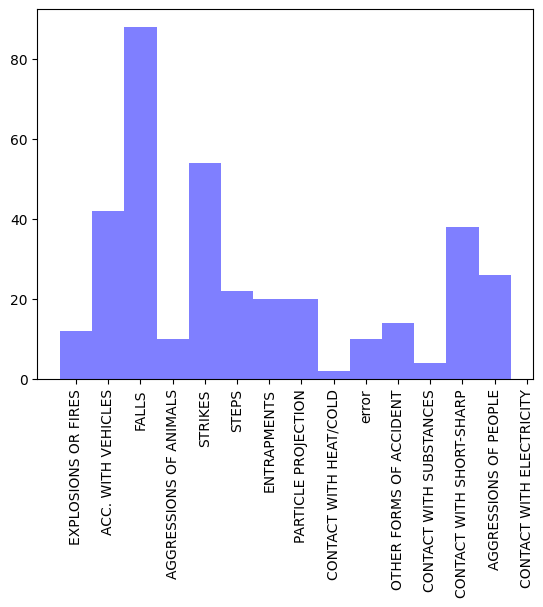

In [ ]:
gpt_mecanismos = list(df_2["mecanismo_true_mapped"])

plt.hist(gpt_mecanismos, bins=range(0, 15), align="left", color="b", alpha=0.5, label="Annotator 1")
plt.xticks(rotation=90)


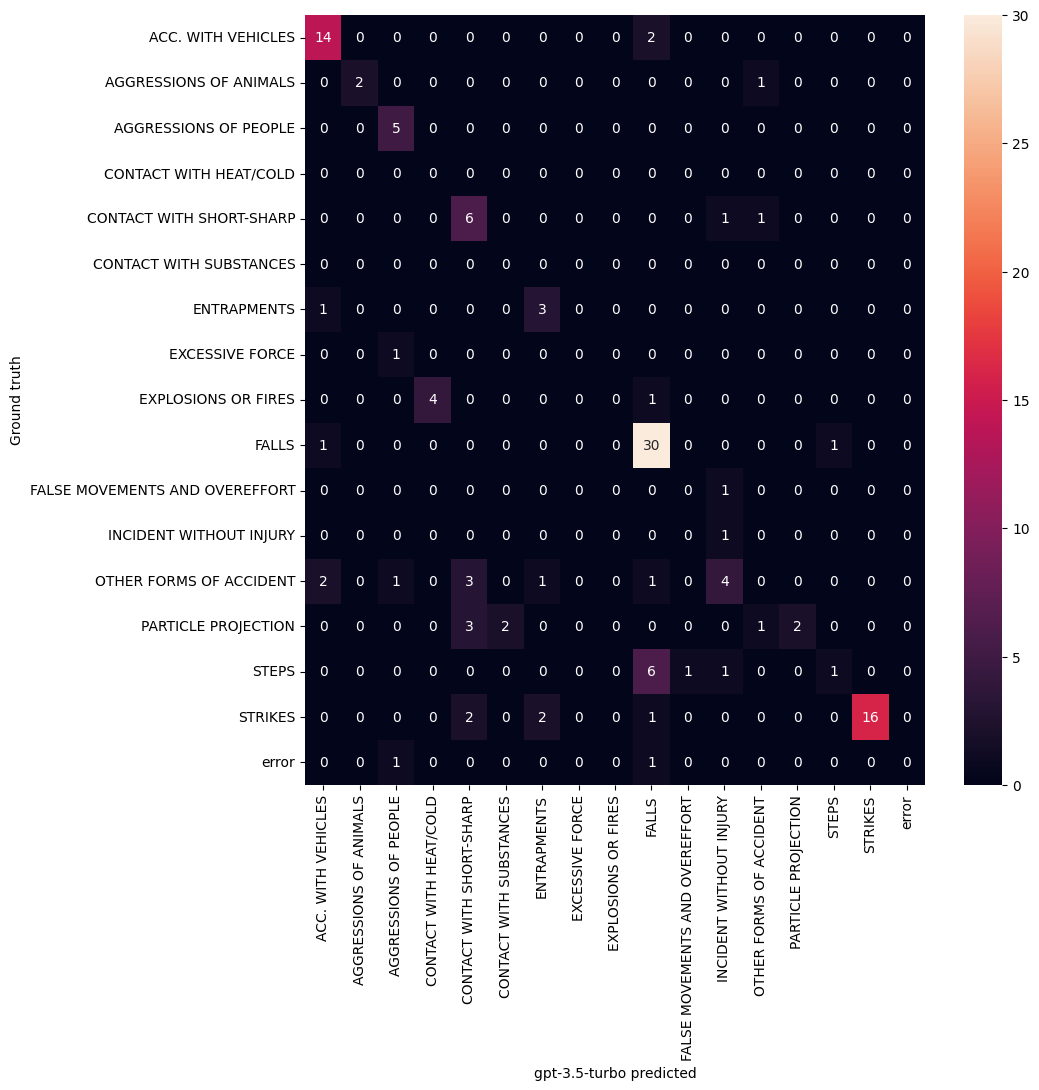

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.5886949590993709, 0.6287512400793651, 0.625)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt



def plot_confusion_matrix(confusion_matrix, labels, clase = None):
    plt.figure(figsize=(10, 10))
    sns.heatmap(confusion_matrix, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
    plt.xlabel("gpt-3.5-turbo predicted")
    plt.ylabel("Ground truth")
    if clase is not None:
        plt.title(f"Confusion matrix of {clase}")
    plt.show()

confusion_matrix_mecanismo = confusion_matrix(df_curation["mecanismo_true_mapped"], df_curation["mecanismo_gpt_mapped"])
classes = list(set(list(df_curation["mecanismo_true_mapped"]))) + list(set(list(df_curation["mecanismo_gpt_mapped"])))
classes = list(set(classes))
classes.sort()

plot_confusion_matrix(confusion_matrix_mecanismo, classes)

f1_mecanismo = f1_score(df_curation["mecanismo_true_mapped"], df_curation["mecanismo_gpt_mapped"], average="weighted")
precision_mecanismo = precision_score(df_curation["mecanismo_true_mapped"], df_curation["mecanismo_gpt_mapped"], average="weighted")
recall_mecanismo = recall_score(df_curation["mecanismo_true_mapped"], df_curation["mecanismo_gpt_mapped"], average="weighted")

f1_mecanismo, precision_mecanismo, recall_mecanismo

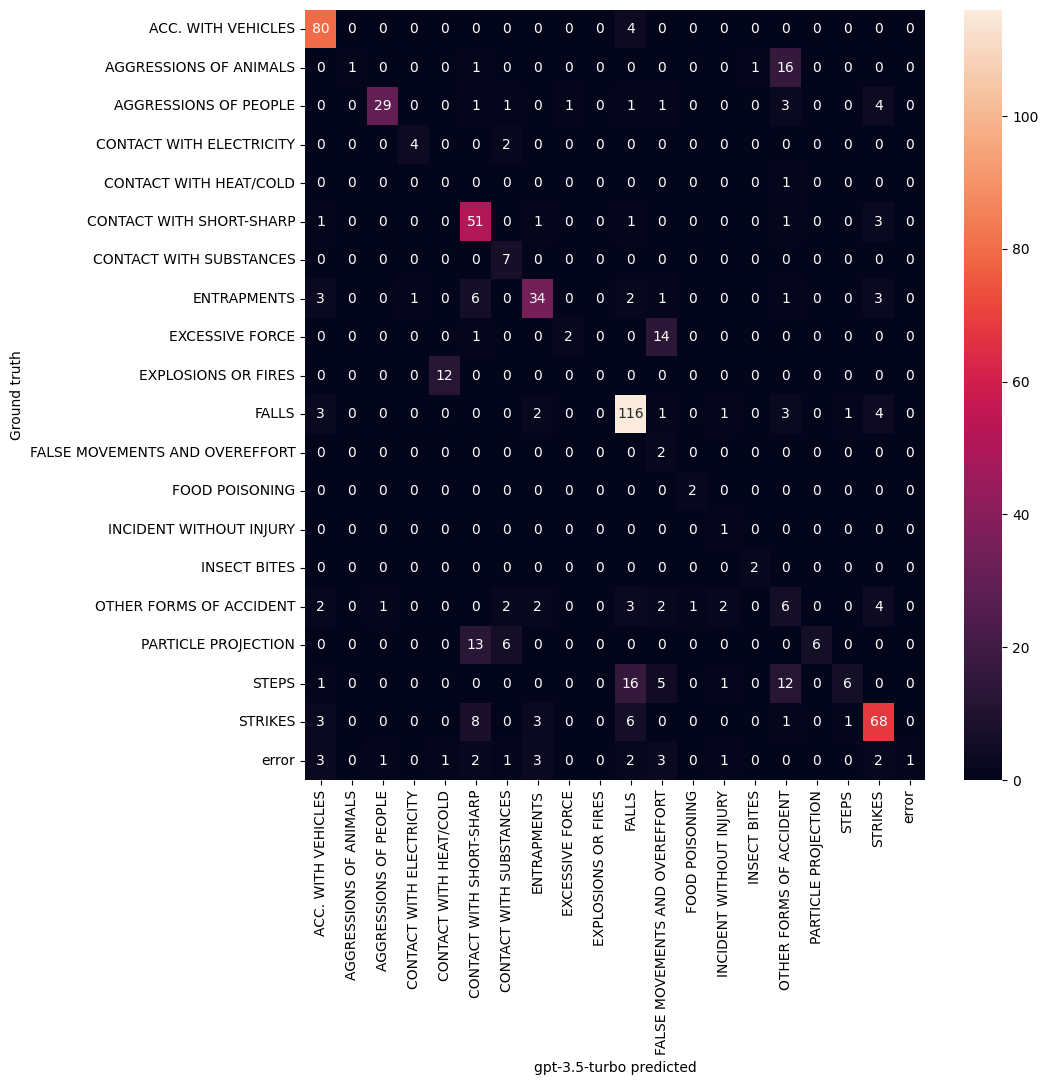

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.6385219770865569, 0.7441741391707059, 0.658267716535433)

In [ ]:

confusion_matrix_mecanismo = confusion_matrix(df_1["mecanismo_true_mapped"], df_1["mecanismo_gpt_mapped"])
classes = list(set(list(df_1["mecanismo_true_mapped"]))) + list(set(list(df_1["mecanismo_gpt_mapped"])))
classes = list(set(classes))
classes.sort()

plot_confusion_matrix(confusion_matrix_mecanismo, classes)


f1_mecanismo = f1_score(df_1["mecanismo_true_mapped"], df_1["mecanismo_gpt_mapped"], average="weighted")
precision_mecanismo = precision_score(df_1["mecanismo_true_mapped"], df_1["mecanismo_gpt_mapped"], average="weighted")
recall_mecanismo = recall_score(df_1["mecanismo_true_mapped"], df_1["mecanismo_gpt_mapped"], average="weighted")

f1_mecanismo, precision_mecanismo, recall_mecanismo

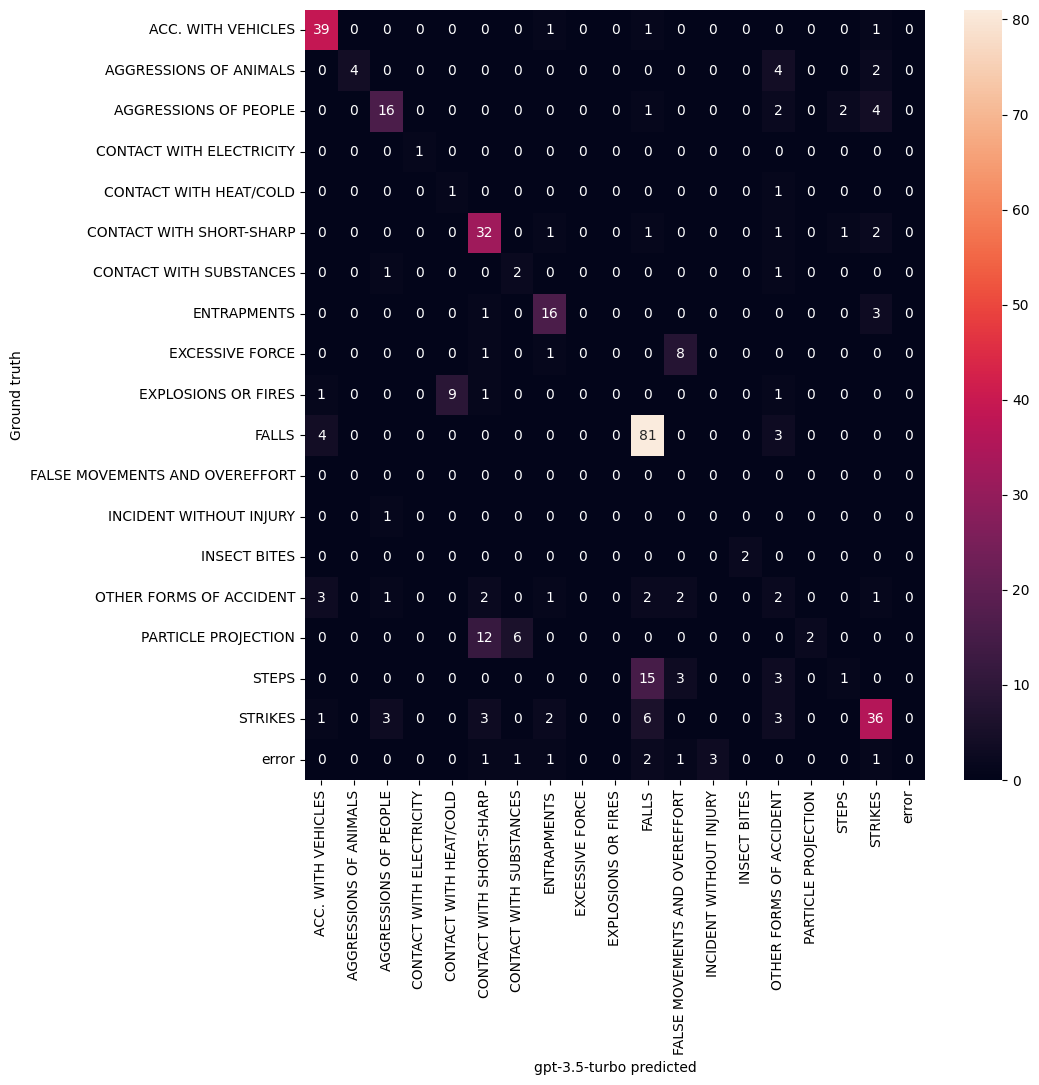

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.591966478603812, 0.624959934724161, 0.6266666666666667)

In [ ]:
confusion_matrix_mecanismo = confusion_matrix(df_2["mecanismo_true_mapped"], df_2["mecanismo_gpt_mapped"])
classes = list(set(list(df_2["mecanismo_true_mapped"]))) + list(set(list(df_2["mecanismo_gpt_mapped"])))
classes = list(set(classes))
classes.sort()

plot_confusion_matrix(confusion_matrix_mecanismo, classes)


f1_mecanismo = f1_score(df_2["mecanismo_true_mapped"], df_2["mecanismo_gpt_mapped"], average="weighted")
precision_mecanismo = precision_score(df_2["mecanismo_true_mapped"], df_2["mecanismo_gpt_mapped"], average="weighted")
recall_mecanismo = recall_score(df_2["mecanismo_true_mapped"], df_2["mecanismo_gpt_mapped"], average="weighted")

f1_mecanismo, precision_mecanismo, recall_mecanismo

In [117]:
df_curation = df_curation[df_curation["mecanismo_true_mapped"] != "error"]
df_1 = df_1[df_1["mecanismo_true_mapped"] != "error"]
df_2 = df_2[df_2["mecanismo_true_mapped"] != "error"]

print(len(df_curation), len(df_1), len(df_2))

126 615 365


In [ ]:
df_union = pd.concat([df_curation, df_1, df_2])

len(df_union)

1106

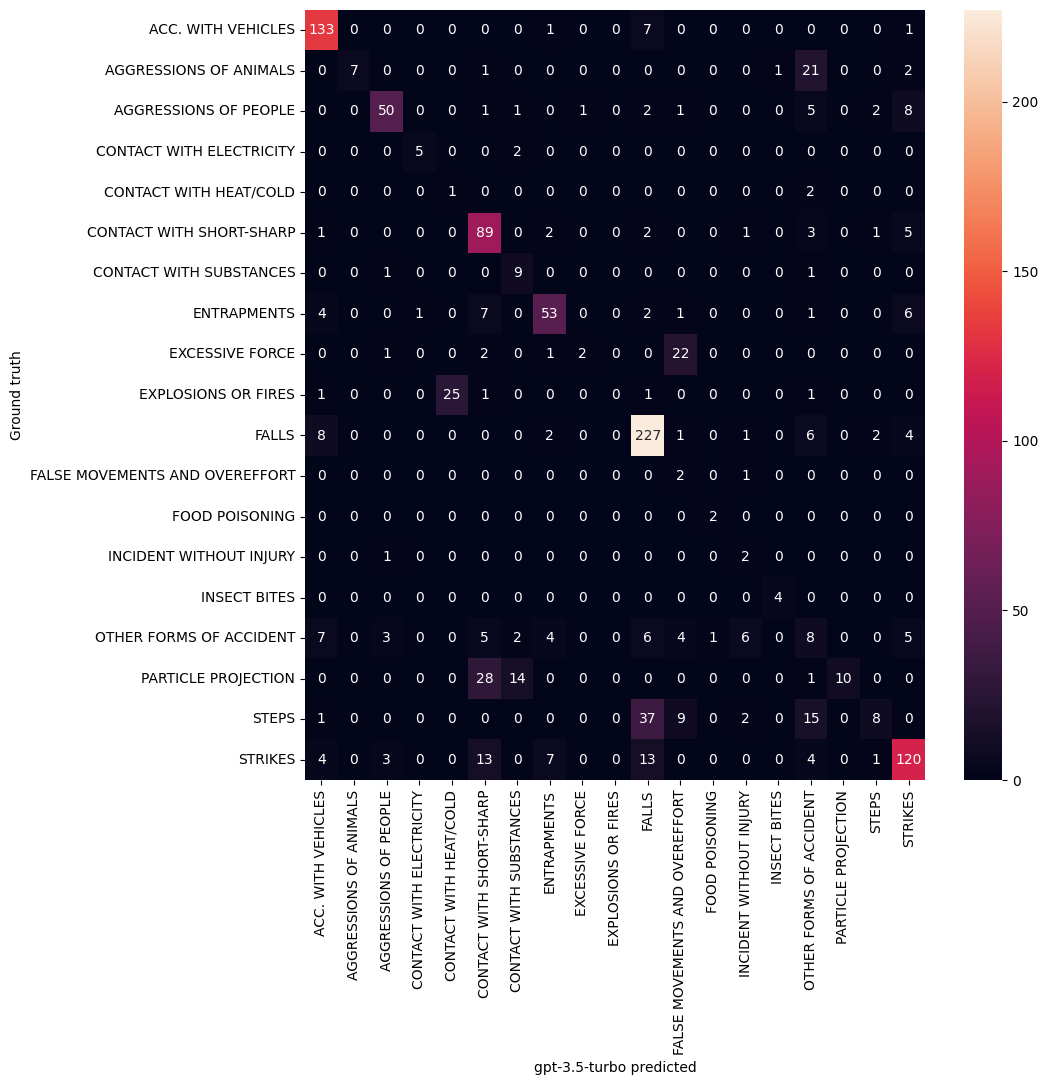

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.6428364138361332, 0.7116704095069444, 0.6618444846292948)

In [ ]:


confusion_matrix_mecanismo = confusion_matrix(df_union["mecanismo_true_mapped"], df_union["mecanismo_gpt_mapped"])
classes = list(set(list(df_union["mecanismo_true_mapped"]))) + list(set(list(df_union["mecanismo_gpt_mapped"])))
classes = list(set(classes))
classes.sort()

plot_confusion_matrix(confusion_matrix_mecanismo, classes)


f1_mecanismo = f1_score(df_union["mecanismo_true_mapped"], df_union["mecanismo_gpt_mapped"], average="weighted")
precision_mecanismo = precision_score(df_union["mecanismo_true_mapped"], df_union["mecanismo_gpt_mapped"], average="weighted")
recall_mecanismo = recall_score(df_union["mecanismo_true_mapped"], df_union["mecanismo_gpt_mapped"], average="weighted")

f1_mecanismo, precision_mecanismo, recall_mecanismo
